# 画像からテーブル構造の抽出を GPT4V と Instructor を使って実現する

GPT-4 を使って画像から表を抽出し、Instructor を使って表を整形するサンプルコード。下記の URL を参照してます。

https://jxnl.github.io/instructor/examples/extracting_tables#top-10-grossing-apps-in-october-2023-ireland-for-ios-platforms


In [6]:
!pip install instructor -Uqq

In [25]:
from io import StringIO
from typing import Annotated, Any
from pydantic import BaseModel, BeforeValidator, PlainSerializer, InstanceOf, WithJsonSchema
import pandas as pd


def md_to_df(data: Any) -> Any:
    # Convert markdown to DataFrame
    if isinstance(data, str):
        return (
            pd.read_csv(
                StringIO(data),  # Process data
                sep="|",
                index_col=1,
            )
            .dropna(axis=1, how="all")
            .iloc[1:]
            .map(lambda x: x.strip())
        )
    return data


MarkdownDataFrame = Annotated[
    InstanceOf[pd.DataFrame],  # Specifies that the type should be an instance of pandas DataFrame
    BeforeValidator(md_to_df),  # Indicates that the md_to_df function should be called before validation
    PlainSerializer(lambda df: df.to_markdown()),  # Defines how the DataFrame should be serialized to markdown
    WithJsonSchema(
        {
            "type": "string",  # Specifies the JSON schema type as a string
            "description": "The markdown representation of the table, each one should be tidy, do not try to join tables that should be seperate",  # Describes the field in the JSON schema
        }
    ),
]

In [26]:
class Table(BaseModel):
    caption: str
    dataframe: MarkdownDataFrame

In [27]:
import instructor
from openai import OpenAI
from typing import Iterable

# Apply the patch to the OpenAI client to support response_model
# Also use MD_JSON mode since the visin model does not support any special structured output mode
client = instructor.patch(OpenAI(), mode=instructor.function_calls.Mode.MD_JSON)


def extract_table(url: str) -> Iterable[Table]:
    return client.chat.completions.create(
        model="gpt-4-vision-preview",
        response_model=Iterable[Table],
        max_tokens=1800,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract table from image."},
                    {"type": "image_url", "image_url": {"url": url}},
                ],
            }
        ],
    )

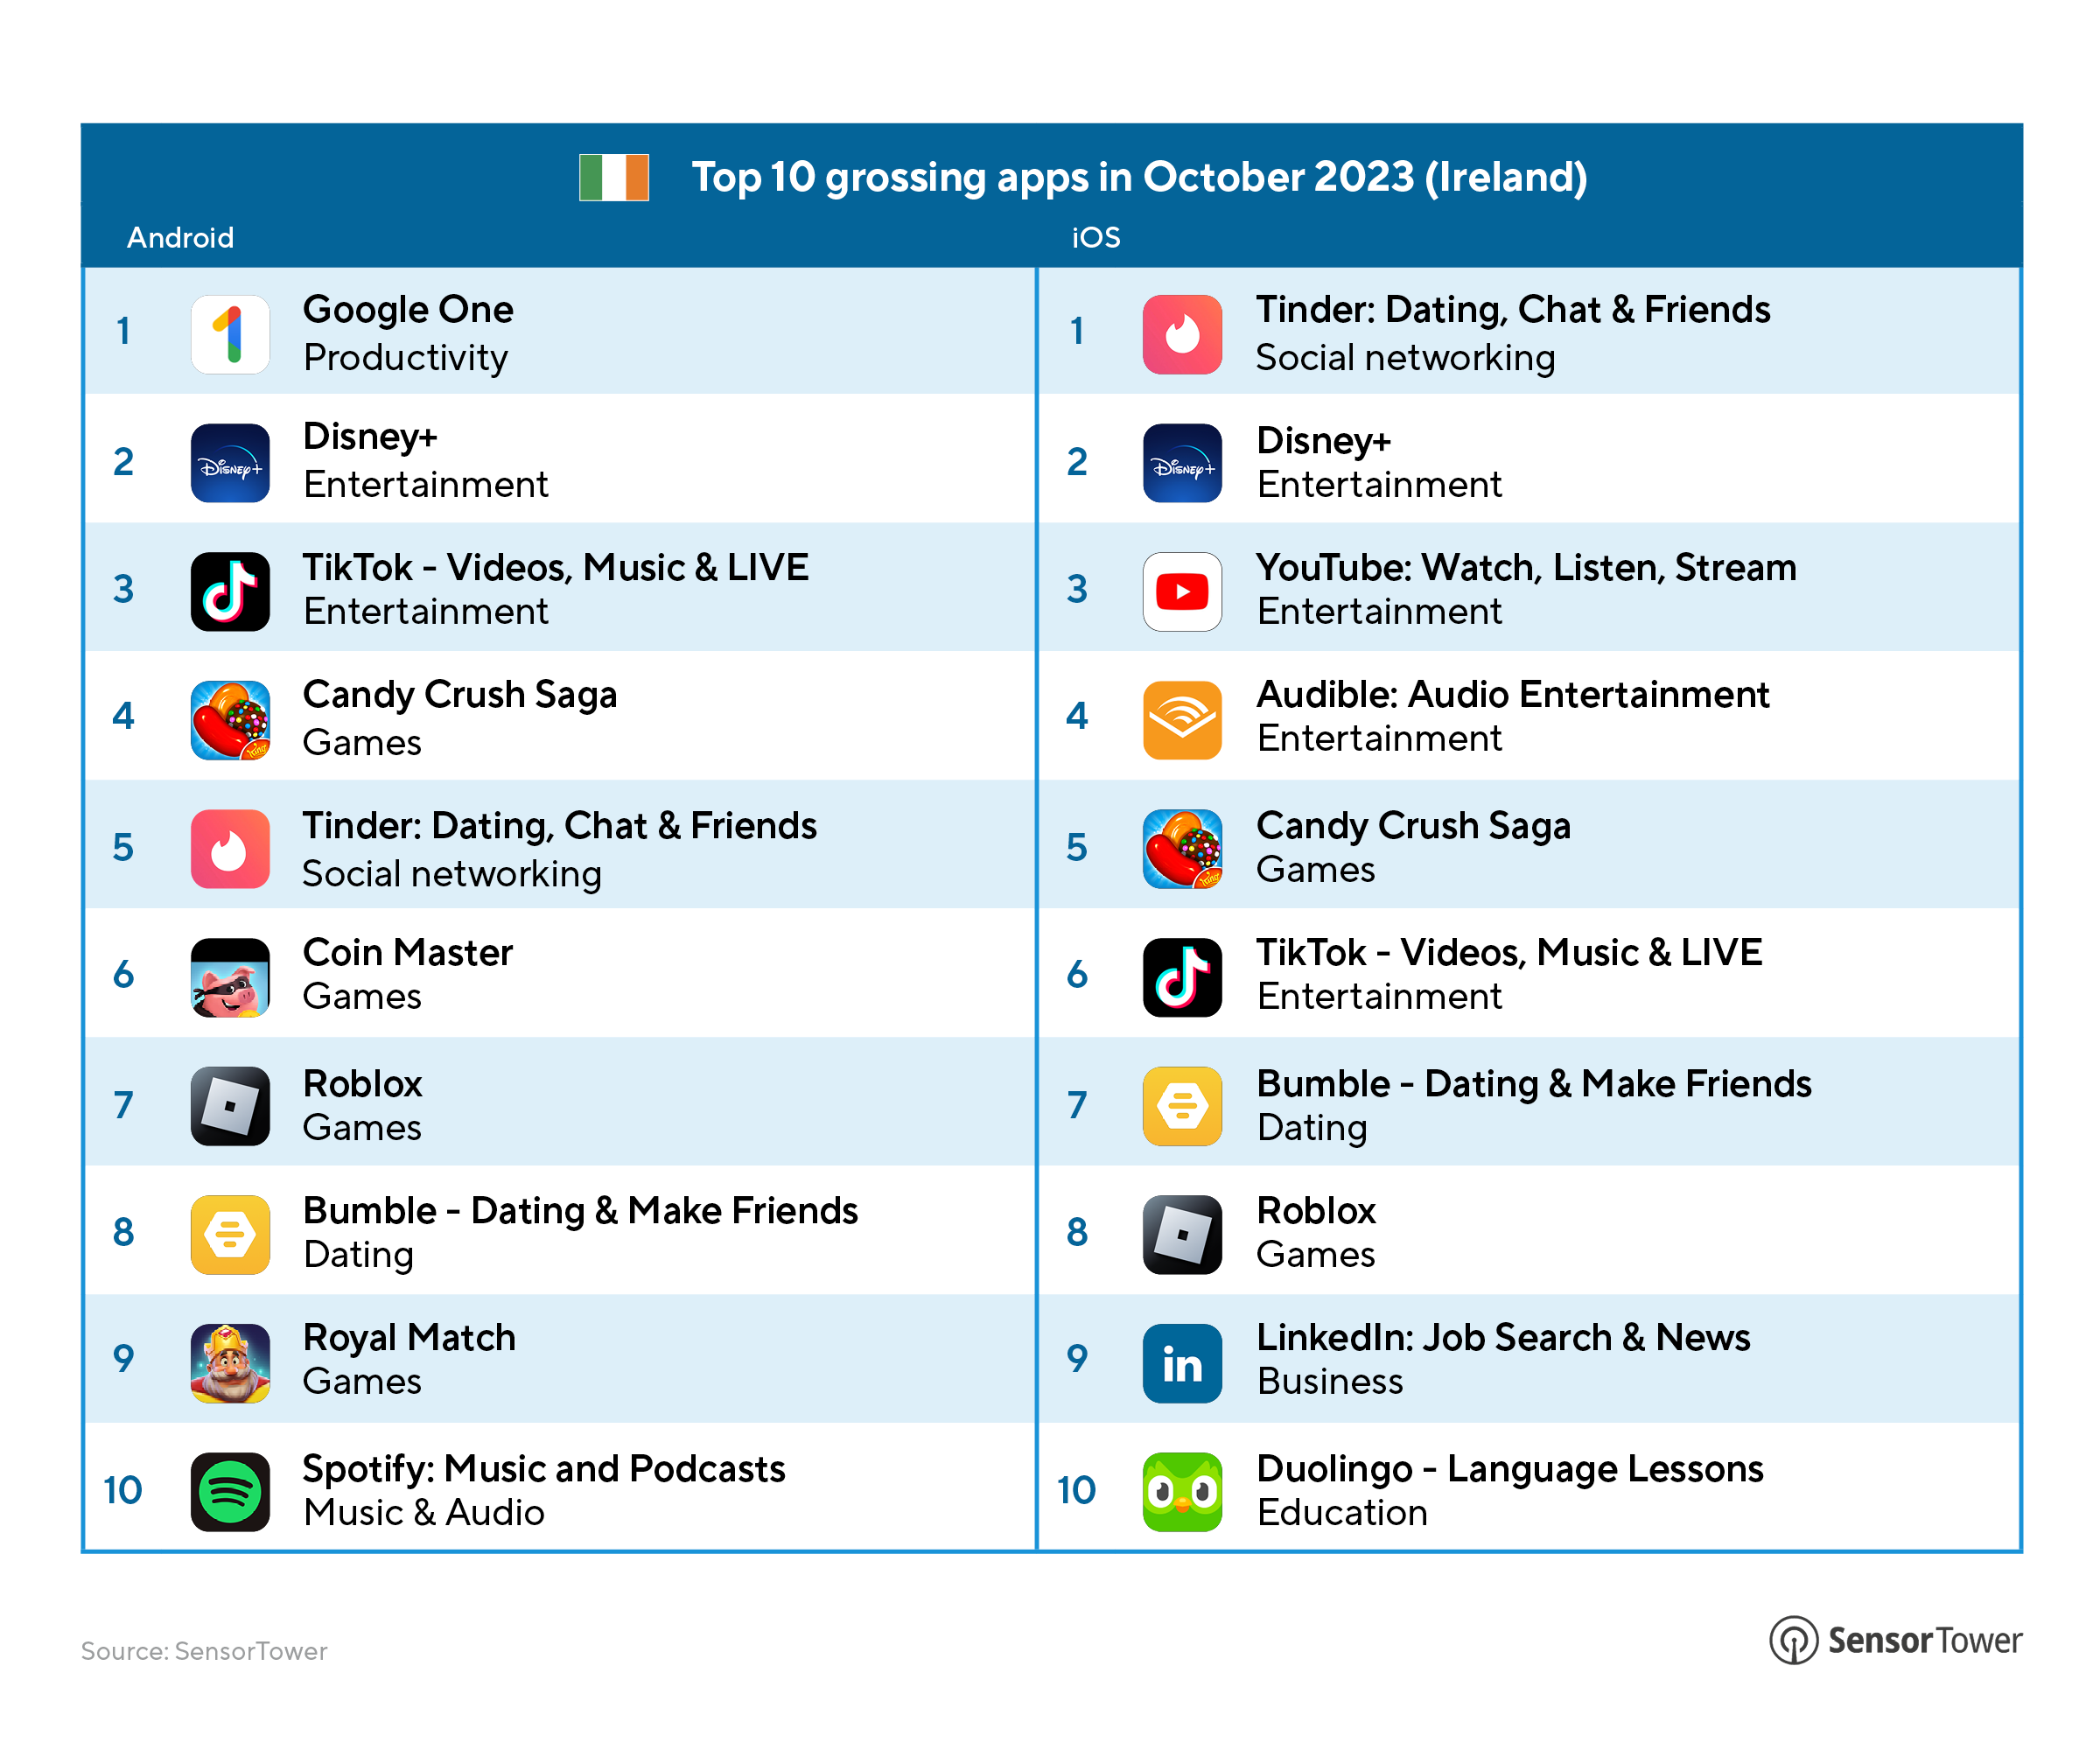

In [8]:
from IPython.display import Image
from urllib.request import urlopen

# 試す画像
url = "https://a.storyblok.com/f/47007/2400x2000/bf383abc3c/231031_uk-ireland-in-three-charts_table_v01_b.png"
Image(urlopen(url).read())

In [28]:
# テーブルの抽出
tables = extract_table(url)
for table in tables:
    print(table.caption, end="\n")
    print(table.dataframe)

Top 10 grossing apps in October 2023 (Ireland) for Android
          App                           Category           
 Rank                                                      
 1                          Google One         Productivity
 2                             Disney+        Entertainment
 3       TikTok - Videos, Music & LIVE        Entertainment
 4                    Candy Crush Saga                Games
 5      Tinder: Dating, Chat & Friends    Social networking
 6                         Coin Master                Games
 7                              Roblox                Games
 8      Bumble - Dating & Make Friends               Dating
 9                         Royal Match                Games
 10        Spotify: Music and Podcasts        Music & Audio
Top 10 grossing apps in October 2023 (Ireland) for iOS
          App                           Category           
 Rank                                                      
 1      Tinder: Dating, Chat & Friends    Soci

In [29]:
tables[0].dataframe

,App,Category
Rank,,
1,Google One,Productivity
2,Disney+,Entertainment
3,"TikTok - Videos, Music & LIVE",Entertainment
4,Candy Crush Saga,Games
5,"Tinder: Dating, Chat & Friends",Social networking
6,Coin Master,Games
7,Roblox,Games
8,Bumble - Dating & Make Friends,Dating
9,Royal Match,Games


In [30]:
tables[1].dataframe

,App,Category
Rank,,
1,"Tinder: Dating, Chat & Friends",Social networking
2,Disney+,Entertainment
3,"YouTube: Watch, Listen, Stream",Entertainment
4,Audible: Audio Entertainment,Entertainment
5,Candy Crush Saga,Games
6,"TikTok - Videos, Music & LIVE",Entertainment
7,Bumble - Dating & Make Friends,Dating
8,Roblox,Games
9,LinkedIn: Job Search & News,Business
